# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [3]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models, utils
from torch.autograd import Variable
from torch.optim import lr_scheduler

import time
import os
import copy
from collections import OrderedDict

import random
from random import randint
from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [4]:
# I do not like to hard code stuff, so that I can re-use it, so I will define constants here:
batch_size = 64

# The following will be used for the comand line application also
c_arch = 'vgg' # choice of model architecture
num_epochs = 8
learning_rate = 0.01
hidden_units = 1024
use_gpu = True
c_drop = 0.5 # droupout choice
feature_extract = True

# in order to match the normalization used when the models were trained, we we need to use the ImageNet standars
# these will be used for our transforms for training, validating and testing data
# these will also be used in the section were we process images
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Image information: In this case, we are using 224x224 images, since it is required by the model.
# I leave it here just in case I ever want to change that
img_px = 224

In [5]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [6]:
# TODO: Define your transforms for the training, validation, and testing sets

# I defined my transforms with the help of a PyTorch official tutorial
# Link: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# Note that for the training, we randomize. Also note that we are using our constants from above
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(img_px),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(img_px + 1),
        transforms.CenterCrop(img_px),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(img_px + 1),
        transforms.CenterCrop(img_px),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

# I defined my transforms with the help of a PyTorch official tutorial
# Link: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid', 'test']}

## Sanity Check #1:

I want to do this project step by step, so first I want to make sure the data was loaded correctly and I also want to display useful information.

In [7]:
# Get the data set sizes:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
# print("Dataset Sizes: ", dataset_sizes)
# print()

# Get the class names from the training dataset:
class_names = image_datasets['train'].classes
# print("Class Names", class_names);
# print()

# Get the # of classes (Useful to figure out what the output size for our last layer in the network should be)
# By inspecting the folder, we can see that it should be 102, but I do not want to hard code this
num_classes = len(class_names)
# print("Number of classes: ", num_classes);

In [8]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")

## Sanity Check #2:

I want to make sure the images were loaded correctly, so I will display some below (will display an actual batch of 64 images):

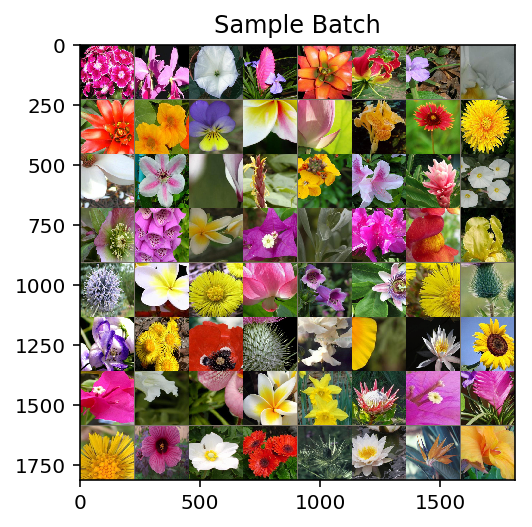

In [9]:
# Again, I used code from the PyTorch.org tutorial on transfer learning
# Link: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title='Sample Batch')

As we can see, we are displaying flower images, so we are doing good so far. We can move on.

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [10]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
# just for fun (and to verify that all is well, I want to print the contents of cat_to_name)
print("Cat to name: ", cat_to_name);
print()
print('Example mapping for cat 70:', cat_to_name['70'])

Cat to name:  {'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orc

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

The model is built from two parts, the features and the classifier. The classifier layer was trained on the ImageNet data set, so it will not work for this project. So we will replace the classifier on our model with our own.

In [11]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [13]:
def initialize_model(model_name, num_classes, feature_extract=True, use_pretrained=True):

    model_ft = None

    if model_name == "resnet":

        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        
        model_ft.fc =  nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(num_ftrs, hidden_units)),
                          ('drop', nn.Dropout(c_drop)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(hidden_units, num_classes)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
        
    elif model_name == "alexnet":

        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[0].in_features
        
        model_ft.classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(num_ftrs, hidden_units)),
                          ('drop', nn.Dropout(c_drop)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(hidden_units, num_classes)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
        
    elif model_name == "vgg":

        model_ft = models.vgg19(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[0].in_features
        
        model_ft.classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(num_ftrs, hidden_units)),
                          ('drop', nn.Dropout(c_drop)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(hidden_units, num_classes)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
        
    elif model_name == "densenet":

        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        
        model_ft.classifier =  nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(num_ftrs, hidden_units)),
                          ('drop', nn.Dropout(c_drop)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(hidden_units, num_classes)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
            
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft

In [14]:
# Initialize the model
model_ft = initialize_model(c_arch, num_classes)

# Print the model
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [15]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized


Params to learn:
	 classifier.fc1.weight
	 classifier.fc1.bias
	 classifier.fc2.weight
	 classifier.fc2.bias


In [16]:
# Setup the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=learning_rate)

# Train and evaluate
model_ft = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/8
----------
train Loss: 3.8133 Acc: 0.1922
valid Loss: 2.6385 Acc: 0.4156

Epoch 2/8
----------
train Loss: 2.5382 Acc: 0.4341
valid Loss: 1.6301 Acc: 0.6589

Epoch 3/8
----------
train Loss: 1.8993 Acc: 0.5615
valid Loss: 1.1898 Acc: 0.7628

Epoch 4/8
----------
train Loss: 1.5163 Acc: 0.6430
valid Loss: 0.9543 Acc: 0.8020

Epoch 5/8
----------
train Loss: 1.2945 Acc: 0.6885
valid Loss: 0.8181 Acc: 0.8130

Epoch 6/8
----------
train Loss: 1.1603 Acc: 0.7131
valid Loss: 0.7015 Acc: 0.8472

Epoch 7/8
----------
train Loss: 1.0258 Acc: 0.7476
valid Loss: 0.6456 Acc: 0.8435

Epoch 8/8
----------
train Loss: 0.9706 Acc: 0.7611
valid Loss: 0.6116 Acc: 0.8484

Training complete in 9m 38s
Best val Acc: 0.848411


Now that our model is build, we can proceed to train it. I have read the tutorial at PyTorch.org, so I will be using code that is similar to what is found at: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.
It also becomes easier to change hyperparameters, since all I have to do is change the function arguments.

With the training function defined, we can proceed to train our model.

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
def check_accuracy_on_test(model, testloader):    
    correct = 0
    total = 0
    model.to(device)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} test images:{}%'.format(dataset_sizes['test'], 100 * correct / total))

In [18]:
check_accuracy_on_test(model_ft, dataloaders['test'])

Accuracy of the network on the 819 test images:83.27228327228327%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [19]:
# print("Our model_ft: \n\n", model_ft, '\n')
# m_state_dict = model_ft.state_dict()
# print("The state dict keys: \n\n", m_state_dict.keys())
# model_ft.class_to_idx = image_datasets['train'].class_to_idx
buffer_model = model_ft

In [20]:
def save_model(model, class_to_idx_mapping):
    # TODO: Save the checkpoint 
    model.class_to_idx = class_to_idx_mapping
    m_state_dict = model.state_dict()
    
    checkpoint = {'output_size': num_classes,
                  'choice_model': c_arch,
                  'hidden_unit' : hidden_units,
                  'learning_rate': learning_rate,
                  'model_state_dict': m_state_dict,
                  'class_to_idx': model.class_to_idx}
    
    torch.save(checkpoint, 'checkpoint.pth')
    print('Model saved!')

In [21]:
save_model(model_ft, image_datasets['train'].class_to_idx)

Model saved!


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [44]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filename):
    # load parameters
    checkpoint = torch.load(filename)
    c_arch = checkpoint['choice_model']
    num_classes = checkpoint['output_size']
    hidden_unit = checkpoint['hidden_unit']
    learning_rate = checkpoint['learning_rate']
    # load the model
    model = initialize_model(c_arch, num_classes)
    # load model state and class idx
    model.load_state_dict(checkpoint['model_state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']  
    
    print("model.class_idx", model.class_to_idx)
    
    return model

In [45]:
# Load the checkpoint:
checkpoint_filename = 'checkpoint.pth'
model_ft = load_checkpoint(checkpoint_filename)

print(model_ft)
# print(model_ft.class_idx)

model.class_idx {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99,

In [ ]:
# print("Our model_ft: \n\n", model_ft, '\n')
# print("The state dict keys: \n\n", model_ft.state_dict().keys())

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [46]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    # open the image
    image = Image.open(image_path)
    
    # Resize the image
    image = image.resize((256, 256))

    # perform center crop
    # https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
    width, height = image.size   # Get dimensions
    # print("image size 1: ", image.size)
    new_height, new_width = 224, 224
    
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    image = image.crop((left, top, right, bottom))
    # print("image size 2: ", image.size)
    
    # convert encoded color channels and convert to floats (divide by 255)
    np_image = np.array(image) / 255
    # print(np_image)
    
    # normalize
    np_image = (np_image - mean) / std
    
    # finally, transpose
    # print("shape 1: ", np_image.shape)
    np_image = np_image.transpose((2, 0, 1))
    # print("transposed shape: ", np_image.shape)
    
    # Originally, I was returning a numpy array, as I thought these were the instructions, but
    # when trying to test, it would not work. 
    # Found solution at: https://knowledge.udacity.com/questions/29173
    # We have to convert to a tensor before we return it
    return torch.Tensor(np_image)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [47]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [48]:
def get_random_image_path():
    # get a random image from the test data set
    rand_folder_idx = randint(1, 102)
    # print(rand_folder_idx)

    # get a random image
    # build the dir/path
    rand_dir = 'flowers/test/' + str(rand_folder_idx) + '/' 

    # get a random file from the dir
    # https://stackoverflow.com/questions/701402/best-way-to-choose-a-random-file-from-a-directory
    rand_img = random.choice(os.listdir(rand_dir))

    # build fuild image path
    rand_img_path = rand_dir + rand_img
    
    return rand_img_path

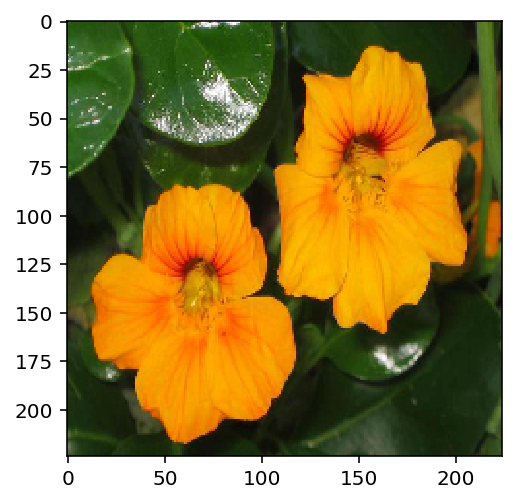

In [49]:
# test random image function
rand_img_path = get_random_image_path()
img = process_image(rand_img_path)
imshow(img)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [52]:
def predict(image_path, model, device, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # set the mode for inference
    model.eval()
    model.to(device)
    
    # process the image
    image = process_image(image_path);
    image = np.expand_dims(image, 0)
    
    img_to_fwd = torch.from_numpy(image)
    img_to_fwd = img_to_fwd.to(device)
    
    # Calculate the class probabilities (softmax) for img
    with torch.no_grad():
        output = model.forward(img_to_fwd)

    ps = torch.exp(output)
    
    probs, classes = ps.topk(5)
    
    # probs and classes are tensors, so we convert to lists so we return
    # as is required
    top_probs = probs.cpu().detach().numpy().tolist()[0]
    top_classes = classes.cpu().detach().numpy().tolist()[0]
    
    # https://knowledge.udacity.com/questions/31597
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    
    classes = []
    
    for cls in top_classes:
        c = idx_to_class[cls]
        classes.append(c)
    
    # top classes are not strings, so we just convert
    return top_probs, classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

predicting image:  flowers/test/11/image_03177.jpg
Probs:  [0.5489605665206909, 0.1586213856935501, 0.07178375124931335, 0.06222262233495712, 0.04988245293498039]

Classes:  ['11', '74', '101', '96', '95']


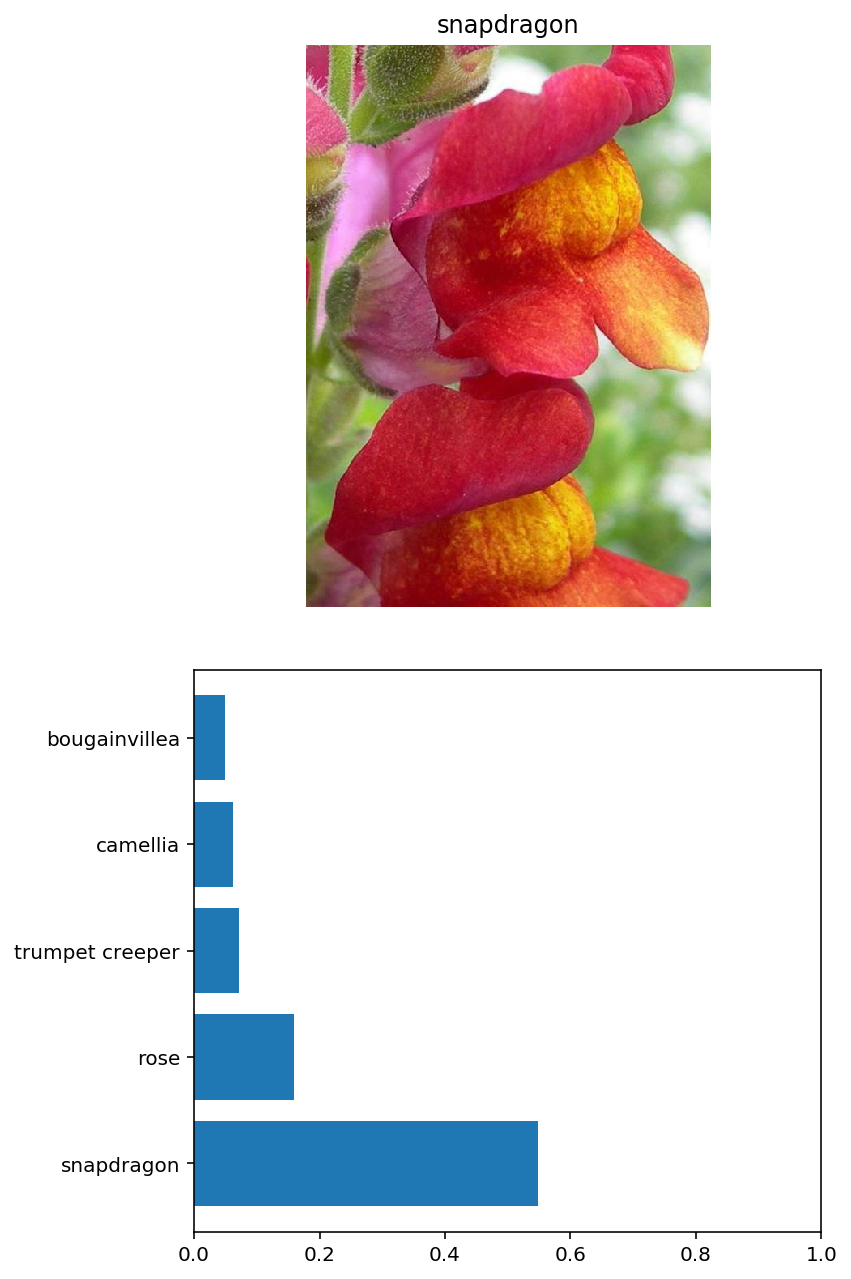

In [54]:
# get a random image
random_image = get_random_image_path()

print("predicting image: ", random_image)
# predict, and get probabilities and classes
probabilities, classes = predict(random_image, model_ft, device)

print("Probs: ", probabilities)
print()
print("Classes: ", classes)

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), nrows=2)

image = Image.open(random_image)
ax1.axis('off')

max_index = np.argmax(probabilities)
max_index_label = cat_to_name[classes[max_index]]

ax1.set_title(max_index_label)
ax1.imshow(image)

labels = []
for cls in classes:
    labels.append(cat_to_name[cls])

y_pos = np.arange(len(labels))

ax2.barh(y_pos, probabilities)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.set_xlim(0, 1.0)

plt.tight_layout()